In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

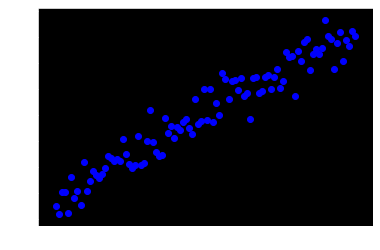

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[-0.9112437]])
b: variable b([0.])
Operations on chainer.Variable: variable([[122.08875]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[-0.9112437]] [[122.08875]]


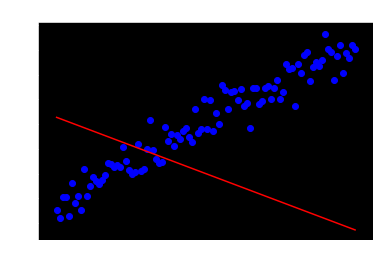

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.59622467)
dloss/dW [[-0.37468788]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.26347706)
Itr 25 loss: variable(0.26347706)
Itr 50 loss: variable(0.26347706)
Itr 75 loss: variable(0.26347706)


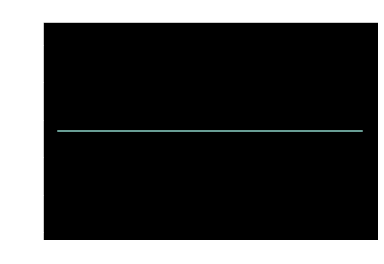

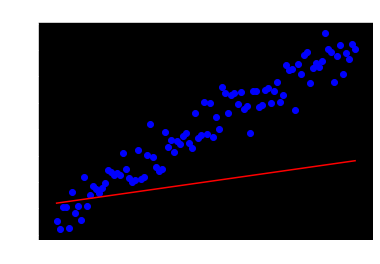

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


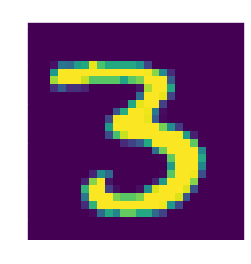

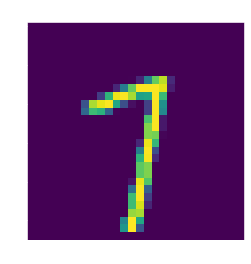

In [7]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
train, test = chainer.datasets.get_mnist()
run(L.Linear(None, 10))

loss: 2.3052096366882324; accuracy: 0.0625
loss: 0.6384266221523285; accuracy: 0.845
loss: 0.5178081488609314; accuracy: 0.8675
loss: 0.407944470345974; accuracy: 0.8825
loss: 0.40686460077762604; accuracy: 0.905
loss: 0.3468897980451584; accuracy: 0.9
loss: 0.2910736387968063; accuracy: 0.92
loss: 0.316351016163826; accuracy: 0.92
loss: 0.37385408461093905; accuracy: 0.9025
loss: 0.3523997563123703; accuracy: 0.9
loss: 0.33307597219944; accuracy: 0.9
loss: 0.3062609013915062; accuracy: 0.9
loss: 0.25320863246917724; accuracy: 0.935
loss: 0.3253918477892876; accuracy: 0.9025
loss: 0.25339267432689666; accuracy: 0.9225
loss: 0.45406064212322234; accuracy: 0.8775
loss: 0.2899514192342758; accuracy: 0.915
loss: 0.2936515772342682; accuracy: 0.9125
loss: 0.2362340658903122; accuracy: 0.935
loss: 0.2655656635761261; accuracy: 0.9325
loss: 0.2837970244884491; accuracy: 0.9175
loss: 0.24352245002985; accuracy: 0.9325
loss: 0.35556416273117064; accuracy: 0.9
loss: 0.2865817794203758; accuracy:

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [9]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        output = F.relu(self.l1(x))
        output = F.relu(self.l2(output))
        output = F.softmax(self.l3(output))
        return output
train, test = chainer.datasets.get_mnist()
run(MLP(200, 10))

loss: 2.304867744445801; accuracy: 0.125
loss: 1.5756138896942138; accuracy: 0.895
loss: 1.5742408561706542; accuracy: 0.885
loss: 1.5659670782089234; accuracy: 0.8925
loss: 1.5513894987106323; accuracy: 0.9075
loss: 1.5503189659118652; accuracy: 0.9125
loss: 1.534153528213501; accuracy: 0.9275
loss: 1.508080334663391; accuracy: 0.9625
loss: 1.532512331008911; accuracy: 0.9325
loss: 1.522956657409668; accuracy: 0.94
loss: 1.5390878534317016; accuracy: 0.92
loss: 1.5085447216033936; accuracy: 0.9575
loss: 1.515583062171936; accuracy: 0.9475
loss: 1.513861083984375; accuracy: 0.95
loss: 1.5332789039611816; accuracy: 0.9275
loss: 1.5066055297851562; accuracy: 0.9525
loss: 1.5133386468887329; accuracy: 0.9475
loss: 1.5174693155288697; accuracy: 0.9425
loss: 1.5241099882125855; accuracy: 0.9375
loss: 1.5266110801696777; accuracy: 0.935
loss: 1.5114359855651855; accuracy: 0.95
loss: 1.5050070333480834; accuracy: 0.9525
loss: 1.5094316959381104; accuracy: 0.9575
loss: 1.5006655836105347; accu

Next you should try to implement logging test loss and see if the model is overfitting.

In [10]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)

    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                accuracies = []
                losses = []
                for batch in test_iter:
                    xs = np.concatenate([datum[0][None, :] for datum in batch])
                    ys = np.array([datum[1] for datum in batch])
                    
                    logits = model(xs)

                    loss = F.softmax_cross_entropy(logits, ys)
                    losses.append(float(loss.data))
                    accuracies.append(float((logits.data.argmax(1) == ys).sum() / batchsize))
                
                stats['test_loss'].append(np.mean(losses))
                stats['test_accuracy'].append(np.mean(accuracies))

                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))
train, test = chainer.datasets.get_mnist()
better_run(MLP(200, 10))

loss: 2.301302433013916; accuracy: 0.1875; test_loss: 2.298383256530762; test_accuracy: 0.2034
loss: 1.577846736907959; accuracy: 0.9075; test_loss: 1.9417719369888307; test_accuracy: 0.5453
loss: 1.5836768388748168; accuracy: 0.8875; test_loss: 1.813816513824463; test_accuracy: 0.6668666666666666
loss: 1.5256057262420655; accuracy: 0.9425; test_loss: 1.7448512133121492; test_accuracy: 0.73165
loss: 1.543555326461792; accuracy: 0.9225; test_loss: 1.706664778366089; test_accuracy: 0.76712
loss: 1.5439726734161376; accuracy: 0.9175; test_loss: 1.6788869485537212; test_accuracy: 0.7931166666666667
loss: 1.533046669960022; accuracy: 0.93; test_loss: 1.658207508959089; test_accuracy: 0.8123571428571429
loss: 1.5545250940322877; accuracy: 0.9; test_loss: 1.6431819696664811; test_accuracy: 0.8264625000000001
loss: 1.5191895723342896; accuracy: 0.94; test_loss: 1.6306143327713014; test_accuracy: 0.838188888888889
loss: 1.5000904941558837; accuracy: 0.96; test_loss: 1.6198496465492251; test_acc

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

In [11]:
class CNN(chainer.Chain):

    def __init__(self, n_out_channels, ksizes, n_out):
        super(CNN, self).__init__()
        with self.init_scope():
            self.layers = []
            info = zip(n_out_channels, ksizes)
            for n_out_channels, ksize in info:
                self.layers.append(L.Convolution2D(None, n_out_channels, ksize))
            self.out = L.Linear(None, n_out)

    def __call__(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))

        output = F.softmax(self.out(x))
        return output

In [12]:
def train_process(model, data, batchsize, optimizer):
    iterator = chainer.iterators.SerialIterator(data, batchsize, repeat=False, shuffle=True)

    accs = []
    losses = []
        
    for itr, batch in enumerate(iterator):
        xs = np.concatenate([datum[0][None, :] for datum in batch])
        ys = np.array([datum[1] for datum in batch])

        logits = model(xs)

        loss = F.softmax_cross_entropy(logits, ys)
        model.cleargrads()
        loss.backward()
        optimizer.update()
            
        losses.append(float(loss.data))
        accs.append(float((logits.data.argmax(1) == ys).sum() / batchsize))
    print('test: acc: %f; loss: %f'%(np.mean(accs), np.mean(losses)))
    return np.mean(accs), np.mean(losses)

def eval_process(model, data, batchsize):
    iterator = chainer.iterators.SerialIterator(data, batchsize, repeat=False, shuffle=True)

    accs = []
    losses = []
        
    for itr, batch in enumerate(iterator):
        xs = np.concatenate([datum[0][None, :] for datum in batch])
        ys = np.array([datum[1] for datum in batch])

        logits = model(xs)

        loss = F.softmax_cross_entropy(logits, ys)
            
        losses.append(float(loss.data))
        accs.append(float((logits.data.argmax(1) == ys).sum() / batchsize))
    print('test: acc: %f; loss: %f'%(np.mean(accs), np.mean(losses)))
    return np.mean(accs), np.mean(losses)

def plot_run(model, train_proc, eval_proc, batchsize=32, num_epochs=20):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)

    train_accs = []
    train_losses = []

    test_accs = []
    test_losses = []

    acc, loss = eval_proc(model, train, batchsize)
    train_accs.append(acc)
    train_losses.append(loss)

    acc, loss = eval_proc(model, test, batchsize)
    test_accs.append(acc)
    test_losses.append(loss)

    for epoch in range(num_epochs):
        print('epoch: %d'%epoch)

        acc, loss = train_proc(model, train, batchsize, optimizer)
        train_accs.append(acc)
        train_losses.append(loss)    
        
        acc, loss = eval_proc(model, test, batchsize)
        test_accs.append(acc)
        test_losses.append(loss)

    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, x, test_accs)
    plt.title("Accuracy")
    plt.legend(['train', 'test'])
    plt.figure()
    plt.plot(x, train_losses, x, test_losses)
    plt.title("Loss")
    plt.legend(['train', 'test'])

test: acc: 0.080167; loss: 2.303847
test: acc: 0.075000; loss: 2.304263
epoch: 0
test: acc: 0.865283; loss: 1.628349
test: acc: 0.914314; loss: 1.535601
epoch: 1
test: acc: 0.936600; loss: 1.530461
test: acc: 0.928627; loss: 1.517170
epoch: 2
test: acc: 0.951700; loss: 1.513288
test: acc: 0.937647; loss: 1.507654
epoch: 3
test: acc: 0.961417; loss: 1.502876
test: acc: 0.943137; loss: 1.501234
epoch: 4
test: acc: 0.967267; loss: 1.496725
test: acc: 0.946275; loss: 1.498107
epoch: 5
test: acc: 0.972583; loss: 1.490936
test: acc: 0.950882; loss: 1.492676
epoch: 6
test: acc: 0.976667; loss: 1.486977
test: acc: 0.951471; loss: 1.492880
epoch: 7
test: acc: 0.978567; loss: 1.484469
test: acc: 0.951667; loss: 1.491840
epoch: 8
test: acc: 0.981033; loss: 1.481615
test: acc: 0.955000; loss: 1.489008
epoch: 9
test: acc: 0.982833; loss: 1.479709
test: acc: 0.955000; loss: 1.488418
epoch: 10
test: acc: 0.983850; loss: 1.478753
test: acc: 0.953039; loss: 1.489020
epoch: 11
test: acc: 0.985650; loss:

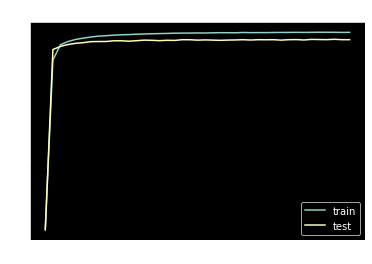

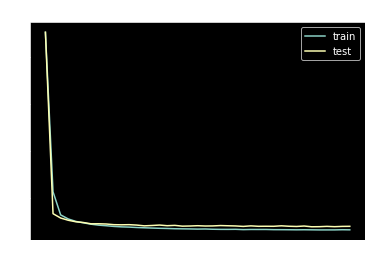

In [13]:
train, test = chainer.datasets.get_mnist()
plot_run(MLP(200, 10), train_process, eval_process, batchsize=300, num_epochs=40)

test: acc: 0.102250; loss: 2.302482
test: acc: 0.102647; loss: 2.302402
epoch: 0
test: acc: 0.620483; loss: 2.054459
test: acc: 0.718137; loss: 1.869504
epoch: 1
test: acc: 0.789600; loss: 1.794218
test: acc: 0.813333; loss: 1.736906
epoch: 2
test: acc: 0.840617; loss: 1.710333
test: acc: 0.837255; loss: 1.685169
epoch: 3
test: acc: 0.859700; loss: 1.671746
test: acc: 0.852157; loss: 1.655623
epoch: 4
test: acc: 0.873450; loss: 1.648074
test: acc: 0.864314; loss: 1.636540
epoch: 5
test: acc: 0.882250; loss: 1.631579
test: acc: 0.872353; loss: 1.623153
epoch: 6
test: acc: 0.889450; loss: 1.619130
test: acc: 0.876863; loss: 1.612320
epoch: 7
test: acc: 0.894833; loss: 1.609394
test: acc: 0.882157; loss: 1.603344
epoch: 8
test: acc: 0.899183; loss: 1.601497
test: acc: 0.885980; loss: 1.595949
epoch: 9
test: acc: 0.903300; loss: 1.594872
test: acc: 0.889412; loss: 1.590588
epoch: 10
test: acc: 0.907183; loss: 1.589209
test: acc: 0.891176; loss: 1.585011
epoch: 11
test: acc: 0.909567; loss:

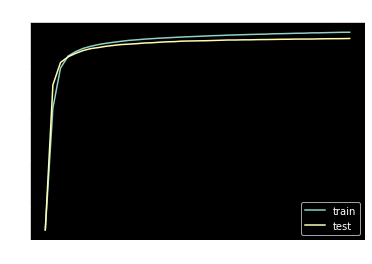

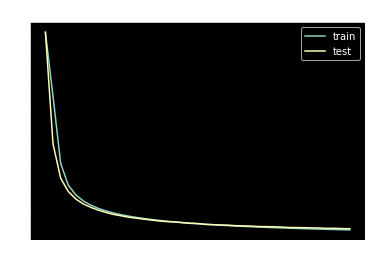

In [14]:
train, test = chainer.datasets.get_mnist(ndim=3)
plot_run(CNN([3, 3, 3], [3, 3, 3], 10), train_process, eval_process, batchsize=300, num_epochs=40)

test: acc: 0.080750; loss: 2.303125
test: acc: 0.080490; loss: 2.303154
epoch: 0
train: acc: 0.013843; loss: 2.308366
test: acc: 0.089412; loss: 2.301645
epoch: 1
train: acc: 0.096045; loss: 2.301502
test: acc: 0.110294; loss: 2.298579
epoch: 2
train: acc: 0.118214; loss: 2.298104
test: acc: 0.143431; loss: 2.295418
epoch: 3
train: acc: 0.151048; loss: 2.294871
test: acc: 0.183333; loss: 2.292197
epoch: 4
train: acc: 0.187201; loss: 2.291637
test: acc: 0.224510; loss: 2.288851
epoch: 5
train: acc: 0.223230; loss: 2.288353
test: acc: 0.270882; loss: 2.285430
epoch: 6
train: acc: 0.265753; loss: 2.284995
test: acc: 0.329902; loss: 2.281963
epoch: 7
train: acc: 0.318421; loss: 2.281549
test: acc: 0.383333; loss: 2.278332
epoch: 8
train: acc: 0.372212; loss: 2.278006
test: acc: 0.431176; loss: 2.274704
epoch: 9
train: acc: 0.421655; loss: 2.274355
test: acc: 0.469706; loss: 2.270825
epoch: 10
train: acc: 0.464131; loss: 2.270590
test: acc: 0.501667; loss: 2.267018
epoch: 11
train: acc: 0.4

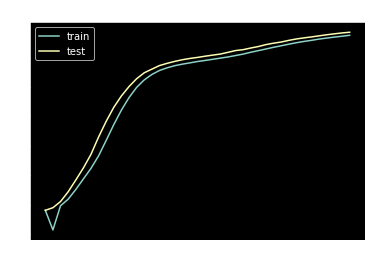

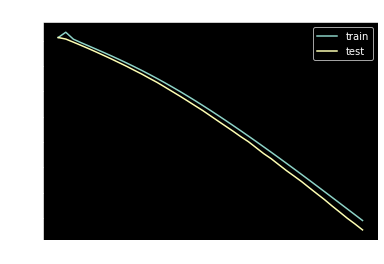

In [15]:
def same_label_train(model, data, batchsize, optimizer):
    dat = {}
    for row in data:
        if row[1] not in dat:
            dat[row[1]] = []
        dat[row[1]].append(row)
    accs = []
    losses = []
        
    for label in dat:
        batch = dat[label]
        xs = np.concatenate([datum[0][None, :] for datum in batch])
        ys = np.array([datum[1] for datum in batch])

        logits = model(xs)

        loss = F.softmax_cross_entropy(logits, ys)
        model.cleargrads()
        loss.backward()
        optimizer.update()
            
        losses.append(float(loss.data))
        accs.append(float((logits.data.argmax(1) == ys).sum() / len(batch)))
    print('train: acc: %f; loss: %f'%(np.mean(accs), np.mean(losses)))
    return np.mean(accs), np.mean(losses)

train, test = chainer.datasets.get_mnist(ndim=3)
plot_run(CNN([3, 3, 3], [3, 3, 3], 10), same_label_train, eval_process, batchsize=300, num_epochs=40)